# **Flan-t5 Model**
This notebook uses Google Flan-t5, fine-tuned with Low Rank Adaptation (LoRA) and LangChain framework, to perform sentiment analysis on our dataset, thereby predicting stock price trends.

The model architecture can be found in the file `models/llmbase.py`, specifically in class `LLMStockPredictBase`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from langchain.prompts import PromptTemplate
from collections import Counter
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
)

from helpers.dataset import get_llm_datasets
from models import LLMStockPredictBase

NLTK resource download complete
CUDA device detected!


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thedu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### (SHARED) Model and Dataset Parameters

In [2]:
from helpers import *

# Model hyperparameters
max_chunk_length = 256
max_chunks = 8
batch_size = 4
num_epochs = 45
learning_rate = 2e-5
aggregation_method = 'attention'
early_stopping_patience = 6
use_wordnet = True
focal_gamma = 2.0

# dataset and dataloaders
df = pd.read_csv(dataset_path)
(_, train_df), (_, val_df), (_, test_df) = get_split_datasets(
    df, use_wordnet=use_wordnet, max_chunk_length=max_chunk_length, max_chunks=max_chunks,
)

Train set: 2979 examples
Validation set: 590 examples
Test set: 615 examples

Testing WordNet enhancement...
Original: I bought my first $AAPL stock in 2010. Since then it has seen a 1,372.29% increase. Tell me again. W...
Enhanced: I bought my first $AAPL stock in 2010 . Since then it has have seen a 1,372.29% increase addition . ...

Original: Why can XPeng P5 deliver outstanding performance in extreme conditions? CEO He Xiaopeng explains the...
Enhanced: Why can tin XPeng P5 deliver outstanding performance in extreme conditions ? CEO He Xiaopeng explain...

Original: @TSM_Myth You dismantled me mentally and emotionally today [SEP] @TSM_Myth You did great! Dont be so...
Enhanced: @TSM_Myth You dismantled level me mentally and emotionally today [SEP] @TSM_Myth You did make great ...



# 1. Flan-t5 Model
As discussed, we will be using LoRA to efficiently generate the weight updates.

In [3]:
model_name = "google/flan-t5-base"
train_dataset, val_dataset = get_llm_datasets(train_df, val_df, model_name)
model = LLMStockPredictBase(model_name)

Map:   0%|          | 0/2979 [00:00<?, ? examples/s]

Map:   0%|          | 0/590 [00:00<?, ? examples/s]

Device set to use cuda:0
The model 'PeftModelForSeq2SeqLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGen

# 2. Fine-tuning

In [4]:
save_dir = model_path + './flant5'

model.train(
    train_dataset,
    val_dataset,
    save=True,
    save_dir=save_dir,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=1,
    logging_dir="./logs",
    save_strategy="no",
    eval_strategy="no",
    label_names=["labels"],
    fp16=True,
    load_best_model_at_end=True,
    report_to="none"
)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
500,0.000000
1000,0.000000


Device set to use cuda:0
The model 'PeftModelForSeq2SeqLM' is not supported for text2text-generation. Supported models are ['BartForConditionalGeneration', 'BigBirdPegasusForConditionalGeneration', 'BlenderbotForConditionalGeneration', 'BlenderbotSmallForConditionalGeneration', 'EncoderDecoderModel', 'FSMTForConditionalGeneration', 'GPTSanJapaneseForConditionalGeneration', 'LEDForConditionalGeneration', 'LongT5ForConditionalGeneration', 'M2M100ForConditionalGeneration', 'MarianMTModel', 'MBartForConditionalGeneration', 'MT5ForConditionalGeneration', 'MvpForConditionalGeneration', 'NllbMoeForConditionalGeneration', 'PegasusForConditionalGeneration', 'PegasusXForConditionalGeneration', 'PLBartForConditionalGeneration', 'ProphetNetForConditionalGeneration', 'Qwen2AudioForConditionalGeneration', 'SeamlessM4TForTextToText', 'SeamlessM4Tv2ForTextToText', 'SwitchTransformersForConditionalGeneration', 'T5ForConditionalGeneration', 'UMT5ForConditionalGeneration', 'XLMProphetNetForConditionalGen

In [62]:
template = """
You are a reliable and excellent financial expert who's been doing sentiment analysis on social media to capture \
its correlation with stock price trends. You are given the following social media posts (each post is separated by \
the character ' [SEP] ', ordered by the time it was created), on the same given date and stock code:

Date: {date}
Stock: {stock}
Posts: "{post}"

The first step you should do is classify the sentiment for each post.
The second step is, based on all of these posts, the given date, and the stock code, predict the stock price trend.
You are only allowed to give predictions based on data prior to the given date.
The third step is to provide your reasoning for your predictions.
Finally, with your reasoning, provide the finalized prediction of the stock price trend (either 'increase' or 'decrease').

Respond in the following JSON format:
- sentiments: the sentiment of each post, either 'negative' or 'positive',
- prediction: 'increase' or 'decrease',
- reasoning: your reasoning, 1-2 sentences long

Your answer:
"""

model.prompt_template_chain(template, input_variables=["date", "stock", "post"])

# 3. Performance Evaluation

### Prompt Template with 3D Inputs (date, stock, post)

In [66]:
def classify_with_voting(row, n_votes=3):
    predictions = []

    for i in range(n_votes):
        try:
            response = model.invoke({
                "date": str(row[date]),
                "stock": row[stock][:450],
                "post": row[post][:512]
            })
            # print(response)

            if "text" in response:
                predictions.append(response["text"].lower())
            else:
                print(f"❌ Run {i+1}: Missing 'prediction' key →", response)

        except Exception as e:
            print(f"❌ Run {i+1} failed for row:\n{row}")
            print("❌ Error:", e)

    if predictions:
        # count and return the majority prediction
        prediction_counts = Counter(predictions)
        majority = prediction_counts.most_common(1)[0][0]
        return majority
    else:
        return "unknown"

### Testing Results

In [68]:
test_df["majority_sentiment"] = test_df.apply(classify_with_voting, axis=1)

Accuracy : 0.5642
F1 Score : 0.4955
Precision: 0.5173
Recall   : 0.5126


<Figure size 600x600 with 0 Axes>

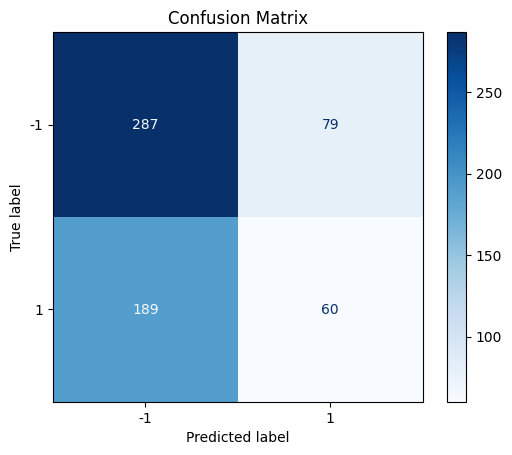

In [108]:
def map_prediction_to_label(prediction_str):
    pred = prediction_str.strip().lower()
    neg = pred.count("negative")
    pos = pred.count("positive")
    inc = pred.count("increase")
    dec = pred.count("decrease")
    if pos > neg:
        return 1
    else:
        return -1

y_true = test_df["label"]
y_pred = test_df["majority_sentiment"].apply(map_prediction_to_label)

# Metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")

print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")

labels = [-1, 1]

cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()